# Celltype annotation migration(mapping) with TOSICA

We know that when all samples cannot be obtained at the same time, it would be desirable to classify the cell types on the first batch of data and use them to annotate the data obtained later or to be obtained in the future with the same standard, without the need to processing and mapping them together again.

So migration(mapping) the reference cell annotation is necessary. This tutorial focuses on how to migration(mapping) the cell annotation from reference scRNA-seq atlas to new scRNA-seq data.

Paper: [Transformer for one stop interpretable cell type annotation](https://www.nature.com/articles/s41467-023-35923-4)

Code: https://github.com/JackieHanLab/TOSICA

![tosica](https://raw.githubusercontent.com/JackieHanLab/TOSICA/main/figure.png)


In [1]:
import omicverse as ov
import scanpy as sc
ov.utils.ov_plot_set()

2023-07-18 14:31:50.271591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 14:31:50.803275: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cudnn/lib:/usr/local/cuda/lib:/usr/local/cudnn/lib:/usr/local/cuda/lib:
2023-07-18 14:31:50.803350: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cudnn/lib:/usr/local/cuda/lib:/usr/l

## Loading data

+ `demo_train.h5ad` :  Braon(GSE84133) and Muraro(GSE85241)

+ `demo_test.h5ad` :  xin(GSE81608), segerstolpe(E-MTAB-5061) and Lawlor(GSE86473)

They can be downloaded at https://figshare.com/projects/TOSICA_demo/158489.

In [2]:
ref_adata = sc.read('demo_train.h5ad')
ref_adata = ref_adata[:,ref_adata.var_names]
print(ref_adata)
print(ref_adata.obs.Celltype.value_counts())

View of AnnData object with n_obs × n_vars = 10600 × 3000
    obs: 'Celltype'
    var: 'Gene Symbol'
alpha          3136
beta           2966
ductal         1290
acinar         1144
delta           793
PSC             524
PP              356
endothelial     273
macrophage       52
mast             25
epsilon          21
schwann          13
t_cell            7
Name: Celltype, dtype: int64


In [4]:
query_adata = sc.read('demo_test.h5ad')
query_adata = query_adata[:,ref_adata.var_names]
print(query_adata)
print(query_adata.obs.Celltype.value_counts())

View of AnnData object with n_obs × n_vars = 4218 × 3000
    obs: 'Celltype'
    var: 'Gene Symbol'
alpha           2011
beta            1006
ductal           414
PP               282
acinar           209
delta            188
PSC               73
endothelial       16
epsilon            7
mast               7
MHC class II       5
Name: Celltype, dtype: int64


In [5]:
print(f"The max of ref_adata is {ref_adata.X.max()}, query_data is {query_adata.X.max()}",)

The max of ref_adata is 8.72524356842041, query_data is 9.2676362991333


By comparing the maximum values of the two data, we can see that the data has been normalised `sc.pp.normalize_total` and logarithmised `sc.pp.log1p`. The same treatment is applied to the data when we use our own data for analysis.

## Download Genesets

Here, we need to download the genesets as pathway at first. You can use `ov.utils.download_tosica_gmt()` to download automatically or manual download from:

- 'GO_bp':'https://figshare.com/ndownloader/files/41460072',
- 'TF':'https://figshare.com/ndownloader/files/41460066',
- 'reactome':'https://figshare.com/ndownloader/files/41460051',
- 'm_GO_bp':'https://figshare.com/ndownloader/files/41460060',
- 'm_TF':'https://figshare.com/ndownloader/files/41460057',
- 'm_reactome':'https://figshare.com/ndownloader/files/41460054',
- 'immune':'https://figshare.com/ndownloader/files/41460063',


In [ ]:
ov.utils.download_tosica_gmt()

## Initialisation the TOSICA model

We first need to train the TOSICA model on the REFERENCE dataset, where omicverse provides a simple class `pyTOSICA`, and all subsequent operations can be done with `pyTOSICA`. We need to set the parameters for model initialisation.

- `adata`: the reference adata object
- `gmt_path`: default pre-prepared mask or path to .gmt files. you can use `ov.utils.download_tosica_gmt()` to obtain the genesets
- `depth`: the depth of transformer model, When it is set to 2, a memory leak may occur
- `label_name`: the reference key of celltype in `adata.obs`
- `project_path`: the save path of TOSICA model
- `batch_size`: indicates the number of cells passed to the programme for training in a single pass

In [6]:
tosica_obj=ov.single.pyTOSICA(adata=ref_adata,
                              gmt_path='genesets/GO_bp.gmt', depth=1,
                              label_name='Celltype',
                              project_path='hGOBP_demo',
                              batch_size=8)

cuda:0
Mask loaded!


## Training the TOSICA model

There're 4 arguments to set when training the TOSICA model.

- pre_weights: The path of the pre-trained weights.
- lr: The learning rate.
- epochs: The number of epochs.
- lrf: The learning rate of the last layer.

In [5]:
tosica_obj.train(epochs=5)

Model builded!


[valid epoch 4] loss: 0.063, acc: 0.991: 100%|██████████| 764/764 [00:03<00:00, 221.62it/s]


Training finished!


Transformer(
  (feature_embed): FeatureEmbed(
    (fe): CustomizedLinear(input_features=3000, output_features=14400, bias=True)
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((48,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=48, out_features=144, bias=True)
        (attn_drop): Dropout(p=0.5, inplace=False)
        (proj): Linear(in_features=48, out_features=48, bias=True)
        (proj_drop): Dropout(p=0.5, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((48,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=48, out_features=192, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=192, out_features=48, bias=True)
        (drop): Dropout(p=0.5, inplace=False)
      )
    )
  )
  (norm): LayerNorm((48,), eps=1e-06, elementwise_affine=True)
  (pre_logits): Identity()
  (head): Linear(in_feat

We can use `.save` to store the `TOSICA` model in `project_path`

In [6]:
tosica_obj.save()

Model saved!


The model can be loaded from `project_path` automatically.

In [7]:
tosica_obj.load()

Model loaded!


## Update with query


In [8]:
new_adata=tosica_obj.predicted(pre_adata=query_adata)

0
4218


## Visualize the reference and mapping

We first compute the lower dimensional space of query_data, where we use omicverse's preprocessing method as well as the mde method for dimensionality reduction

To visualize the PCA’s embeddings, we use the `pymde` package wrapper in omicverse. This is an alternative to UMAP that is GPU-accelerated.

In [15]:
ov.pp.scale(query_adata)
query_adata=ov.pp.pca(query_adata,layer='scaled',n_pcs=50)
sc.pp.neighbors(query_adata, n_neighbors=15, n_pcs=50,
               use_rep='scaled|original|X_pca')
query_adata.obsm["X_mde"] = ov.utils.mde(query_adata.obsm["scaled|original|X_pca"])
query_adata

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


AnnData object with n_obs × n_vars = 4218 × 3000
    obs: 'Celltype'
    var: 'Gene Symbol'
    uns: 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'neighbors'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'
    obsp: 'distances', 'connectivities'

Since new_adata and query_adata have the same cells, their low-dimensional spaces are also the same. So we proceed directly to the assignment operation.

In [16]:
new_adata.obsm=query_adata[new_adata.obs.index].obsm.copy()
new_adata.obsp=query_adata[new_adata.obs.index].obsp.copy()
new_adata

AnnData object with n_obs × n_vars = 4218 × 299
    obs: 'Prediction', 'Probability', 'Celltype'
    obsm: 'scaled|original|X_pca', 'X_mde'
    obsp: 'distances', 'connectivities'

Since the predicted cell types are not exactly the same as the original cell types, the colours are not exactly the same. For the visualisation effect, we manually set the colour of the predicted cell type with the original cell type.

In [18]:
import numpy as np
col = np.array([
"#98DF8A","#E41A1C" ,"#377EB8", "#4DAF4A" ,"#984EA3" ,"#FF7F00" ,"#FFFF33" ,"#A65628" ,"#F781BF" ,"#999999","#1F77B4","#FF7F0E","#279E68","#FF9896"
]).astype('<U7')

celltype = ("alpha","beta","ductal","acinar","delta","PP","PSC","endothelial","epsilon","mast","macrophage","schwann",'t_cell')
new_adata.obs['Prediction'] = new_adata.obs['Prediction'].astype('category')
new_adata.obs['Prediction'] = new_adata.obs['Prediction'].cat.reorder_categories(list(celltype))
new_adata.uns['Prediction_colors'] = col[1:]

celltype = ("MHC class II","alpha","beta","ductal","acinar","delta","PP","PSC","endothelial","epsilon","mast")
new_adata.obs['Celltype'] = new_adata.obs['Celltype'].astype('category')
new_adata.obs['Celltype'] = new_adata.obs['Celltype'].cat.reorder_categories(list(celltype))
new_adata.uns['Celltype_colors'] = col[:11]

[<AxesSubplot: title={'center': 'Celltype'}, xlabel='X_mde1', ylabel='X_mde2'>,
 <AxesSubplot: title={'center': 'Prediction'}, xlabel='X_mde1', ylabel='X_mde2'>]

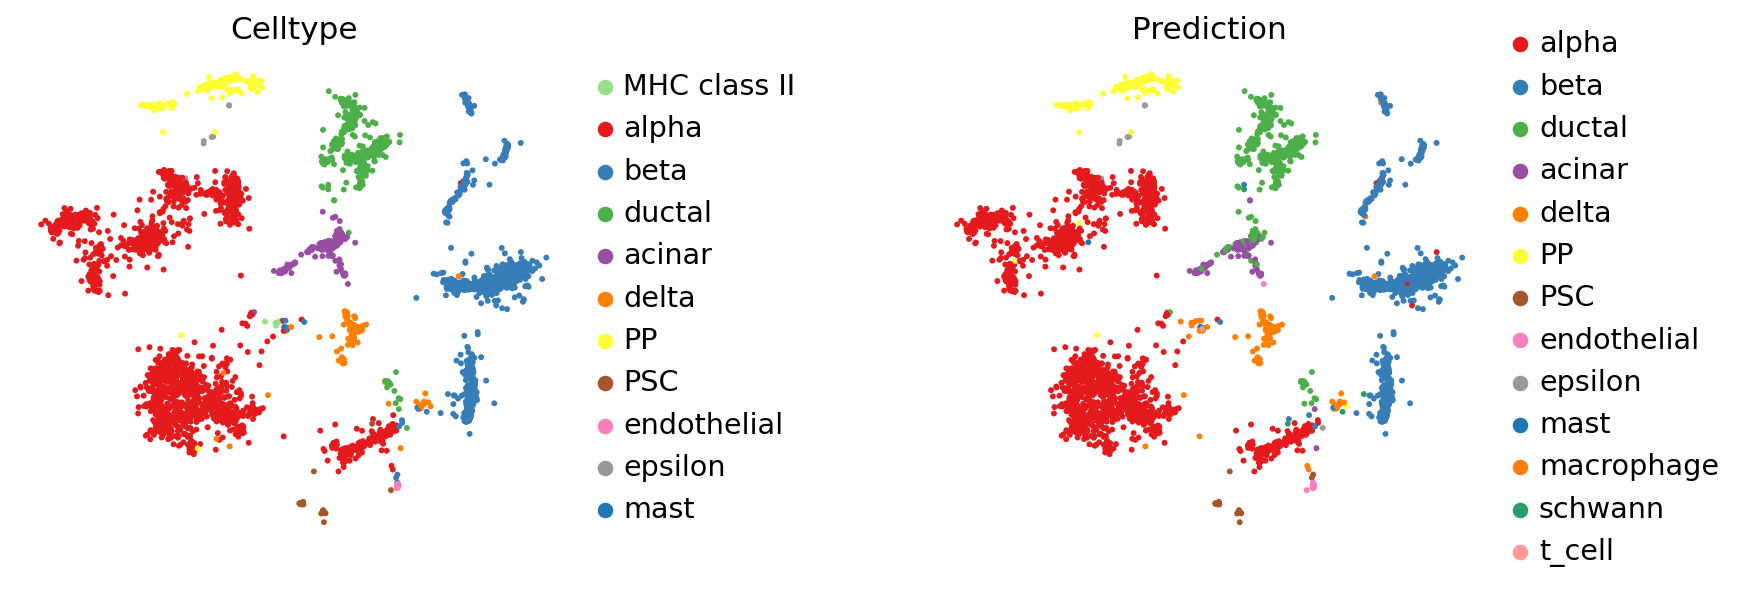

In [24]:
sc.pl.embedding(
    new_adata,
    basis="X_mde",
    color=['Celltype', 'Prediction'],
    frameon=False,
    #ncols=1,
    wspace=0.5,
    #palette=ov.utils.pyomic_palette()[11:],
    show=False,
)

## Pathway attention

TOSICA has another special feature, which is the ability to computationally use self-attention mechanisms to find pathways associated with cell types. Here we demonstrate the approach of this downstream analysis.

We first need to filter out the predicted types of cells with cell counts less than 5.

In [30]:
cell_idx=new_adata.obs['Prediction'].value_counts()[new_adata.obs['Prediction'].value_counts()<5].index
new_adata=new_adata[~new_adata.obs['Prediction'].isin(cell_idx)]

We then used `sc.tl.rank_genes_groups` to calculate the differential pathways with the highest attention across cell types. This differential pathway is derived from the gmt genesets used for the previous calculation.

In [31]:
sc.tl.rank_genes_groups(new_adata, 'Prediction', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


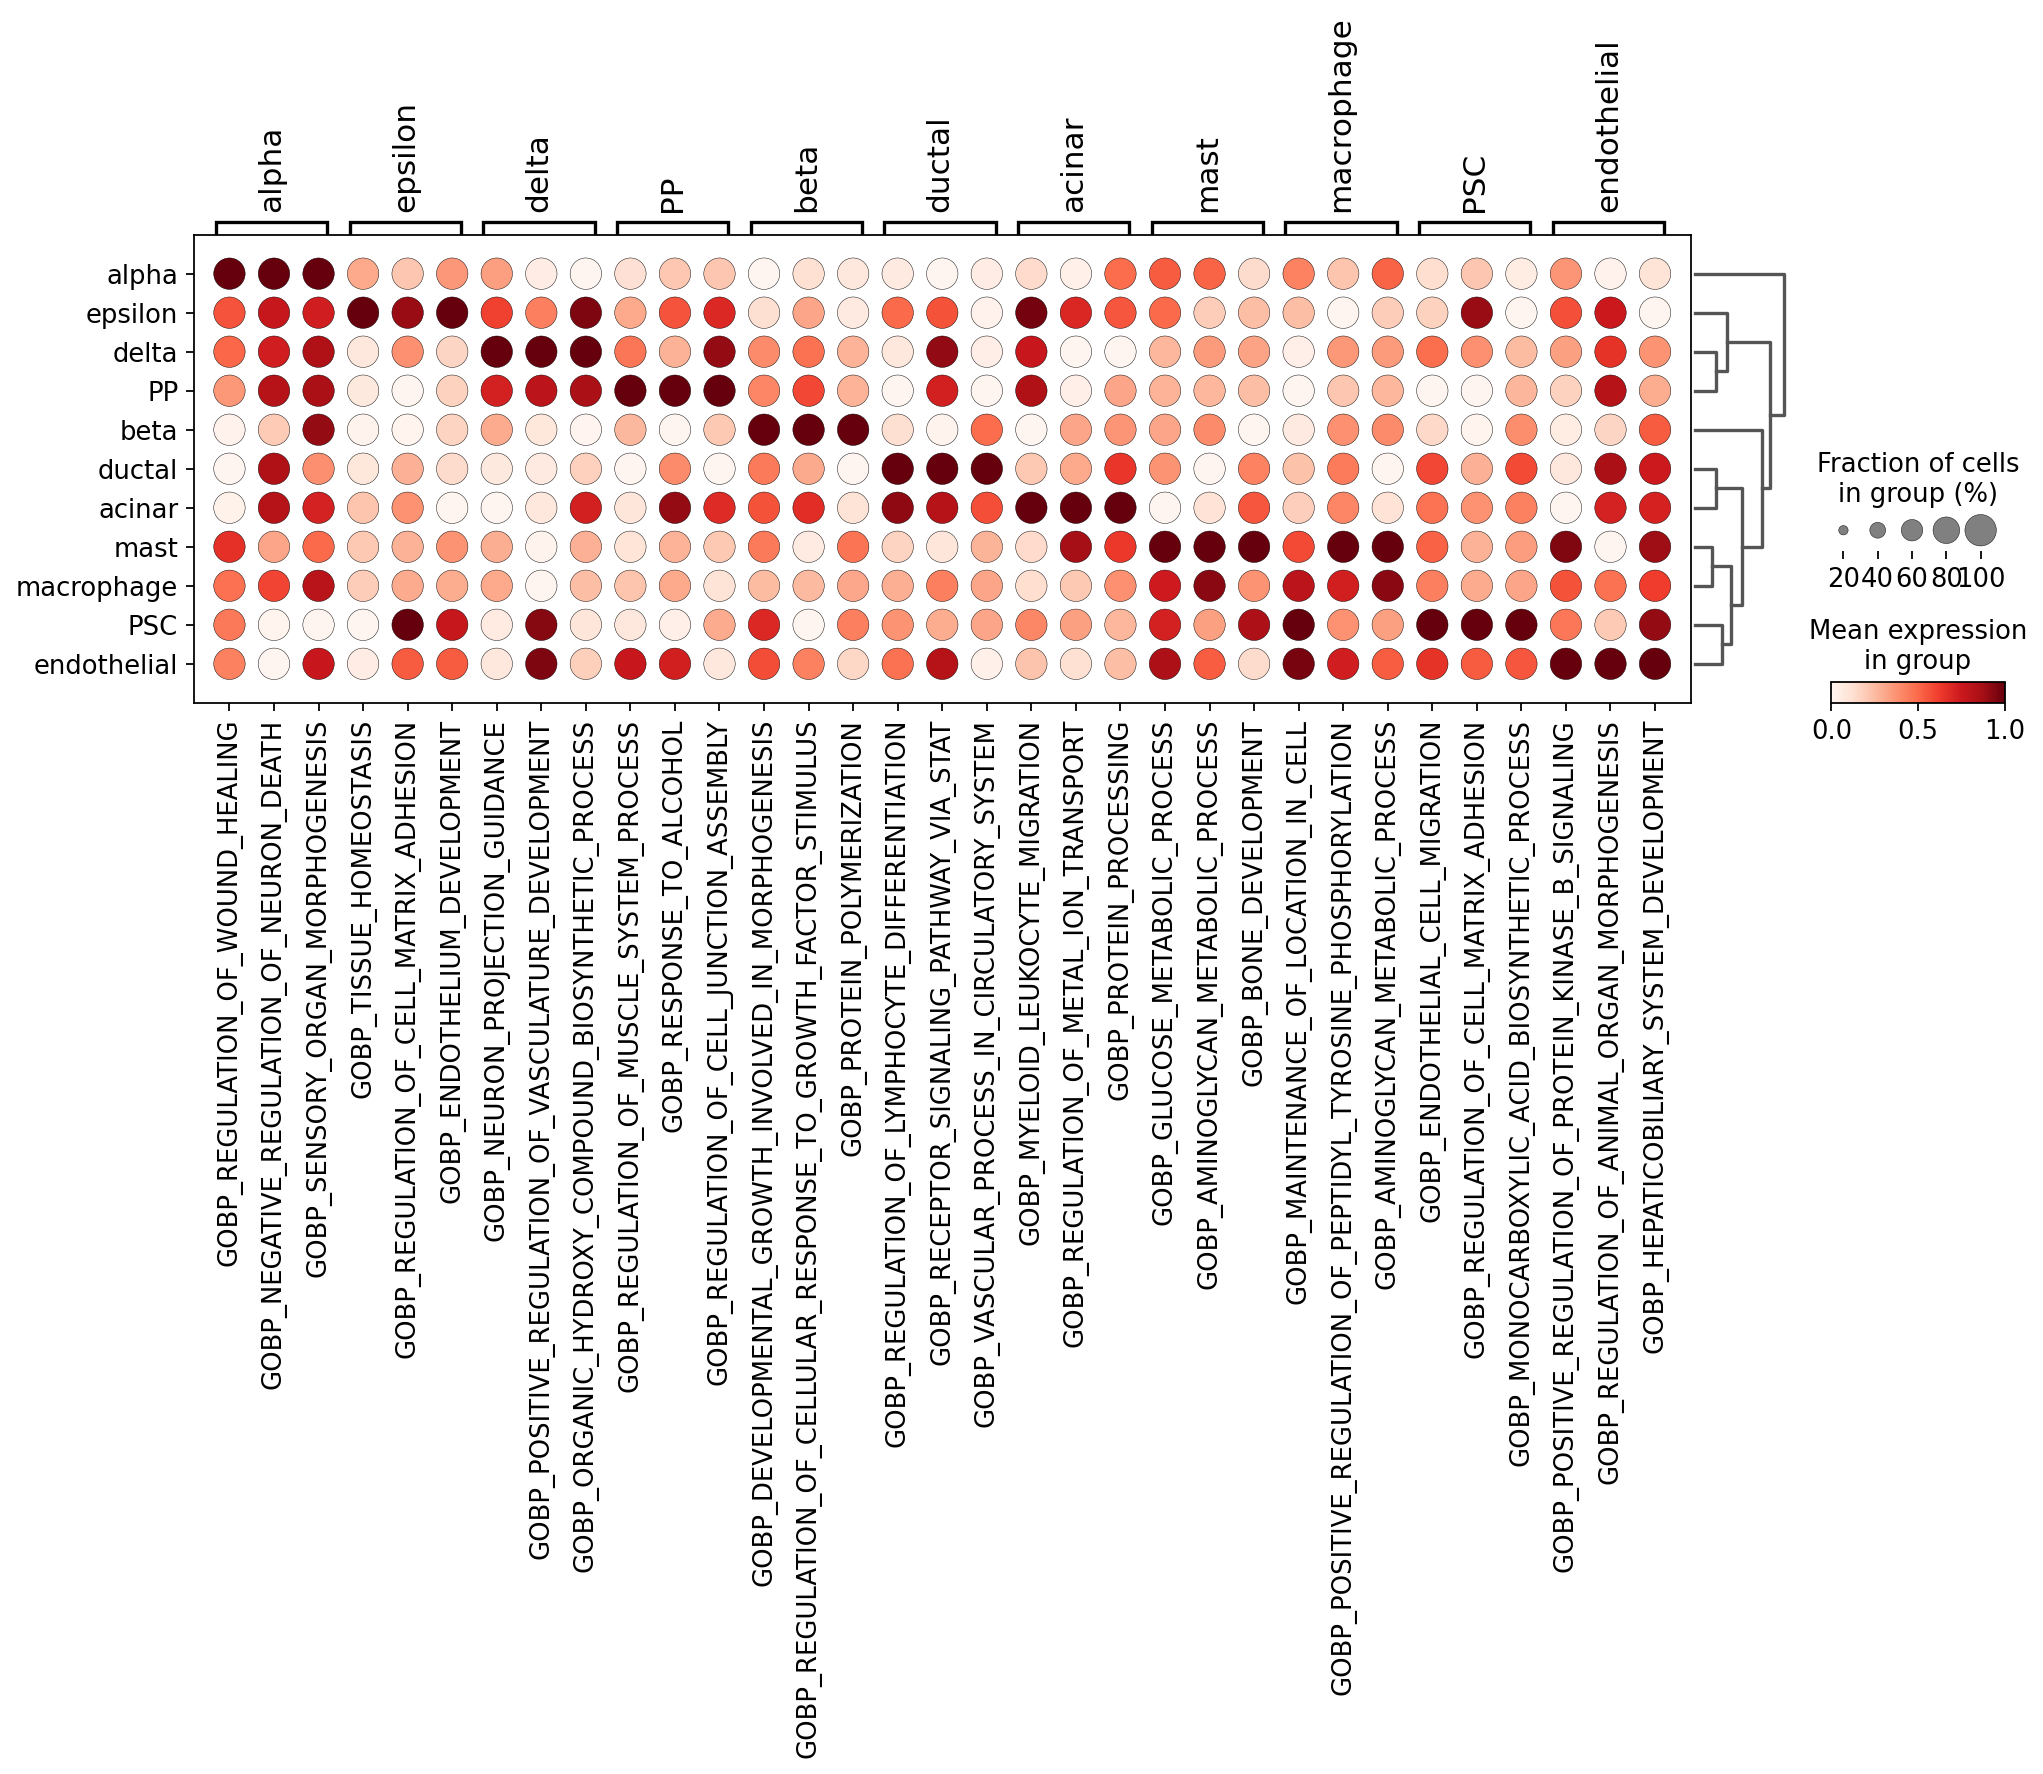

In [34]:
sc.pl.rank_genes_groups_dotplot(new_adata,
                                n_genes=3,standard_scale='var',)

If you call omciverse to complete a TOSICA analysis, don't forget to cite the following literature:

```
@article{pmid:36641532,
journal = {Nature communications},
doi = {10.1038/s41467-023-35923-4},
issn = {2041-1723},
number = {1},
pmid = {36641532},
pmcid = {PMC9840170},
address = {England},
title = {Transformer for one stop interpretable cell type annotation},
volume = {14},
author = {Chen, Jiawei and Xu, Hao and Tao, Wanyu and Chen, Zhaoxiong and Zhao, Yuxuan and Han, Jing-Dong J},
note = {[Online; accessed 2023-07-18]},
pages = {223},
date = {2023-01-14},
year = {2023},
month = {1},
day = {14},
}


@misc{doi:10.1101/2023.06.06.543913,
doi = {10.1101/2023.06.06.543913},
publisher = {Cold Spring Harbor Laboratory},
title = {OmicVerse: A single pipeline for exploring the entire transcriptome universe},
author = {Zeng, Zehua and Ma, Yuqing and Hu, Lei and Xiong, Yuanyan and Du, Hongwu},
note = {[Online; accessed 2023-07-18]},
date = {2023-06-08},
year = {2023},
month = {6},
day = {8},
}
```